In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Analysis with real life option data

In this notebook, I performed analysis with several real-life non-dividend paying equity options, comparing the implied volatility structure for both call and put options. I also computed the American premium and the disagreement between Black-Scholes and binomial tree simulations for the put options. The data are sourced from OptionMetrics Ivy DB US, accessed using Wharton Research Data Services. The data aren't shared publicly due to licensing restrictions. 

In [5]:
# Load the CSV file
data_options_path = os.path.expanduser("data_options.csv")
data_security_path = os.path.expanduser("data_security.csv")

# Read the data
df_options = pd.read_csv(data_options_path, encoding='utf-8')
df_security = pd.read_csv(data_security_path, encoding='utf-8')
starting_date = df_options['date'].unique()[0]

# Filter out tickers that are not suitable for Black-Scholes analysis
# Reasons for exclusion:
# - European-style options: SPX, DJX (indices)
# - Significant dividend payers: PG, JNJ, AAPL, F
# (European Black-Scholes doesn't account for dividends or American early exercise)
excluded_tickers = ['SPX', 'DJX', 'PG', 'JNJ', 'F', 'AAPL']
included_tickers = ['AMZN', 'MSFT', 'NVDA', 'TSLA', 'META']#df_options['ticker'].unique().tolist()

df_options = df_options[df_options['ticker'].isin(included_tickers)]
df_security = df_security[df_security['ticker'].isin(included_tickers)]

print(f"Data loaded successfully!")
print(f"Included tickers: {', '.join(included_tickers)}")
print(f"Options Data Shape: {df_options.shape[0]} rows × {df_options.shape[1]} columns")
print(f"Security Data Shape: {df_security.shape[0]} rows × {df_security.shape[1]} columns")

Data loaded successfully!
Included tickers: AMZN, MSFT, NVDA, TSLA, META
Options Data Shape: 15766 rows × 38 columns
Security Data Shape: 1260 rows × 19 columns


/var/folders/z4/h6nt6cb92jl9jsxg6g7h076m0000gp/T/ipykernel_3119/1368085444.py:6: DtypeWarning: Columns (32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_options = pd.read_csv(data_options_path, encoding='utf-8')


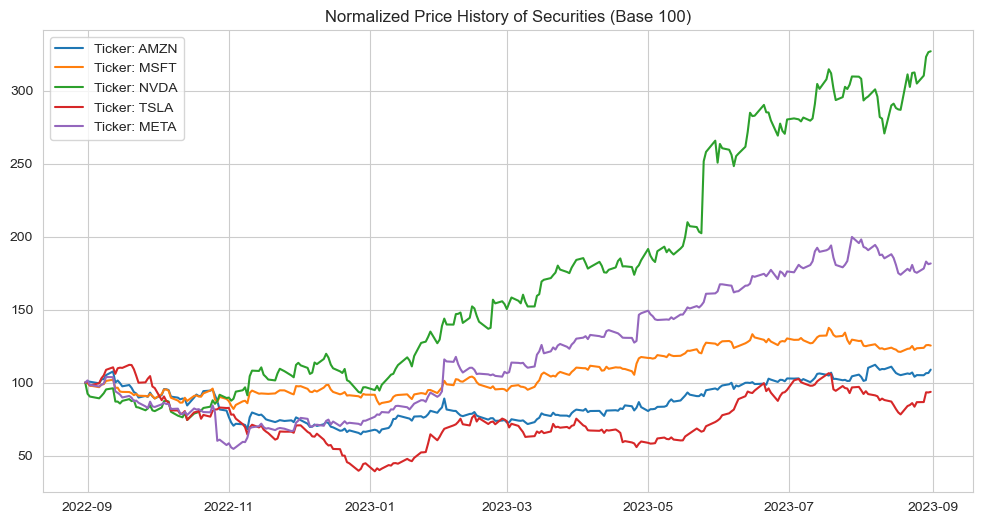

In [6]:
# Test: plot the price history of the securities
# for all security id, plot the close price history
for secid in df_security['secid'].unique():
    price_history = df_security[df_security['secid'] == secid]['close']
    normalized_price = (price_history / price_history.iloc[0]) * 100
    ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
    time = pd.to_datetime(df_security[df_security['secid'] == secid]['date'])
    plt.plot(time, normalized_price, label=f'Ticker: {ticker}')
plt.title("Normalized Price History of Securities (Base 100)")
plt.legend()
plt.show()

# Implied volatility smile for call options (pure Black-Scholes)

The implied volatility smile for call options can be simulated using a pure Black-Scholes model. Below, interest rate is obtained from the zero-coupon yield curve for the bond with the contract length closest to the option.

In [7]:
# Test: examine the call option prices
# The option price should yield some measures of implied volatility using Black-Scholes model
from src.black_scholes import implied_volatility_call

def get_interest_rate(contract_length, data_rate = os.path.expanduser("~/Downloads/zerocouponyieldcurve.csv")):
    df_rate = pd.read_csv(data_rate, encoding='utf-8')
    df_rate_start = df_rate[df_rate['date'] == starting_date].copy()
    # Find the closest rate entry based on contract length
    days_diff = np.abs(df_rate_start['days'] - contract_length)
    closest_idx = days_diff.idxmin()
    closest_rate_entry = df_rate_start.loc[closest_idx]
    r = closest_rate_entry['rate'] / 100  # Convert percentage to decimal
    return r, closest_rate_entry


def _get_option_entries_for_ticker_and_exdate(ticker, target_exdate=None, exdate_id=None, option_type='C', verbose=False):
    """
    Helper function to extract option entries for a given ticker and expiration date.
    
    Parameters:
    -----------
    ticker : str
        Ticker symbol (e.g., 'AMZN', 'MSFT')
    target_exdate : str or datetime-like, optional
        Target expiration date. The function will find the closest available expiration date.
    exdate_id : int, optional
        If provided, use this index to select expiration date instead of target_exdate.
    option_type : str, default='C'
        'C' for call options, 'P' for put options
    verbose : bool, default=False
        Print debug information
    
    Returns:
    --------
    tuple : (option_entries, spot_price, r, t, actual_exdate)
    """
    if target_exdate is None and exdate_id is None:
        raise ValueError("Either target_exdate or exdate_id must be provided.")
    if target_exdate is not None and exdate_id is not None:
        raise ValueError("Only one of target_exdate or exdate_id must be provided.")

    df_options_secid = df_options[df_options['ticker'] == ticker]
    secid = df_security[df_security['ticker'] == ticker]['secid'].values[0]
    if verbose:
        print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

    # Find the expiration date
    available_exdates = df_options_secid['exdate'].unique()
    if exdate_id is None:
        target_exdate_dt = pd.to_datetime(target_exdate)
        available_exdates_dt = pd.to_datetime(available_exdates)
        time_diffs = np.abs(available_exdates_dt - target_exdate_dt)
        exdate_id = time_diffs.argmin()
    
    exdate = available_exdates[exdate_id]
    
    if verbose:
        if target_exdate is not None:
            print(f"Target expiration date: {target_exdate}")
        print(f"Closest available expiration date: {exdate}")
    
    # Calculate time parameters
    contract_length = (pd.to_datetime(exdate) - pd.to_datetime(df_options_secid['date'].min())).days
    t = contract_length / 365  # Time to expiration in years

    # Get risk-free interest rate
    r, closest_rate_entry = get_interest_rate(contract_length)

    if verbose:
        print(f"Contract length: {contract_length} days")
        print(f"Closest rate entry has date {closest_rate_entry['date']} and rate {closest_rate_entry['rate']:.4f}%")

    # Get spot price
    spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]

    # Extract option entries
    option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
    option_entries['strike_price'] = option_entries['strike_price'] / 1000  # Convert from units of 1000
    
    # Filter by option type
    option_entries = option_entries[option_entries['cp_flag'] == option_type].copy()
    
    return option_entries, spot_price, r, t, exdate


def get_implied_call_volatilities_for_ticker_and_exdate(ticker, target_exdate=None, exdate_id=None, verbose=False):
    """
    Calculate implied volatilities for call options given a ticker and target expiration date.
    
    Parameters:
    -----------
    ticker : str
        Ticker symbol (e.g., 'AMZN', 'MSFT')
    target_exdate : str or datetime-like, optional
        Target expiration date. The function will find the closest available expiration date.
        Can be in format 'YYYY-MM-DD' or any format parseable by pd.to_datetime()
    exdate_id : int, optional
        If provided, use this index to select expiration date instead of target_exdate.
        Note: only one of target_exdate or exdate_id should be provided.
    
    Returns:
    --------
    tuple : (call_entries, spot_price, r, t, actual_exdate)
        call_entries : DataFrame with call options and calculated implied volatilities
        spot_price : float, current spot price of the stock
        r : float, risk-free interest rate
        t : float, time to expiration in years
        actual_exdate : str, the actual expiration date used (closest to target)
    """
    call_entries, spot_price, r, t, exdate = _get_option_entries_for_ticker_and_exdate(
        ticker, target_exdate, exdate_id, option_type='C', verbose=verbose
    )

    call_entries['implied_volatility_calculation'] = call_entries.apply(
        lambda row: implied_volatility_call(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )
    return call_entries, spot_price, r, t, exdate

def plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, exdate, label = "Call"):
    """
    Plot the implied volatility smile for call options.
    
    Parameters:
    -----------
    call_entries : DataFrame
        DataFrame containing call options with calculated implied volatilities.
    ticker : str
        Ticker symbol of the stock.
    spot_price : float
        Current spot price of the stock.
    r : float
        Risk-free interest rate.
    t : float
        Time to expiration in years.
    exdate : str
        Expiration date of the options.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(call_entries['strike_price'], call_entries['implied_volatility_calculation'], 
                marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
                label='Calculated IV')

    # The data also comes with implied volatility directly
    plt.scatter(call_entries['strike_price'], call_entries['impl_volatility'], 
                marker='x', s=60, color='blue', alpha=0.6,
                label='Dataset IV')
    plt.axvline(x=spot_price, color='r', linestyle='--', label='Spot Price')
    plt.title(f'Implied Volatility Smile for {ticker} {label} Options\nExpiration Date: {exdate}')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

Analyzing options for secid: 101310, ticker: AMZN
Target expiration date: 2023-01-30
Closest available expiration date: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%
Valid IV entries: 214, Invalid IV entries: 0


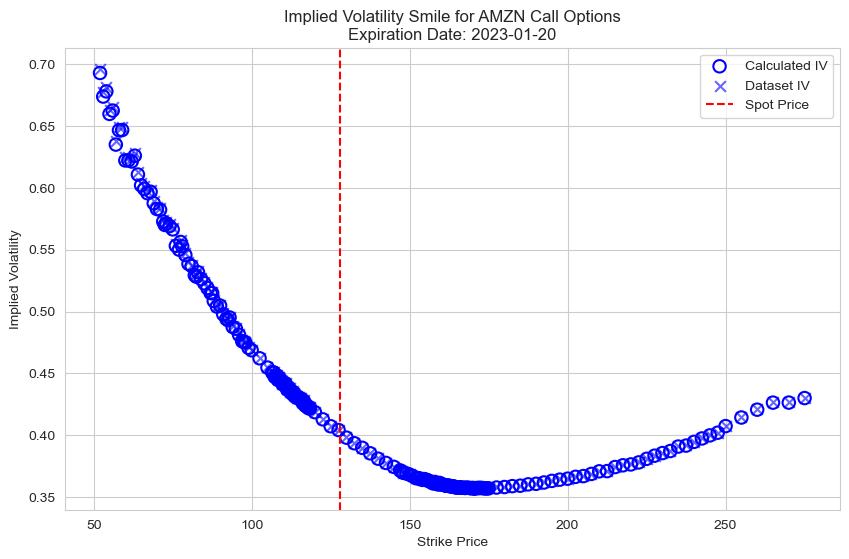

In [8]:
# Example: Use a specific target date instead of an index
# You can specify any date, and the function will find the closest available expiration date
target_date = "2023-01-30"  # Or use a date from your data

# Pick a security id
ticker = "AMZN"
exdate_id = 10

call_entries, spot_price, r, t, actual_exdate = get_implied_call_volatilities_for_ticker_and_exdate(ticker, target_date, verbose=True)

valid_iv = call_entries[call_entries['implied_volatility_calculation'].notna()].copy()
invalid_iv = call_entries[call_entries['implied_volatility_calculation'].isna()].copy()
print(f"Valid IV entries: {valid_iv.shape[0]}, Invalid IV entries: {invalid_iv.shape[0]}")

plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, actual_exdate)

Analyzing options for secid: 108321, ticker: NVDA
Target expiration date: 2023-01-30
Closest available expiration date: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%
Valid IV entries: 114, Invalid IV entries: 13
Invalid IV entries:
       strike_price  implied_volatility_calculation  impl_volatility
31440          10.0                             NaN              NaN
31471          15.0                             NaN              NaN
31485          20.0                             NaN              NaN
31498          25.0                             NaN              NaN
31510          30.0                             NaN              NaN
31520          35.0                             NaN              NaN
31529          40.0                             NaN              NaN
31536          45.0                             NaN              NaN
31543           5.0                             NaN              NaN
31544          50.0            

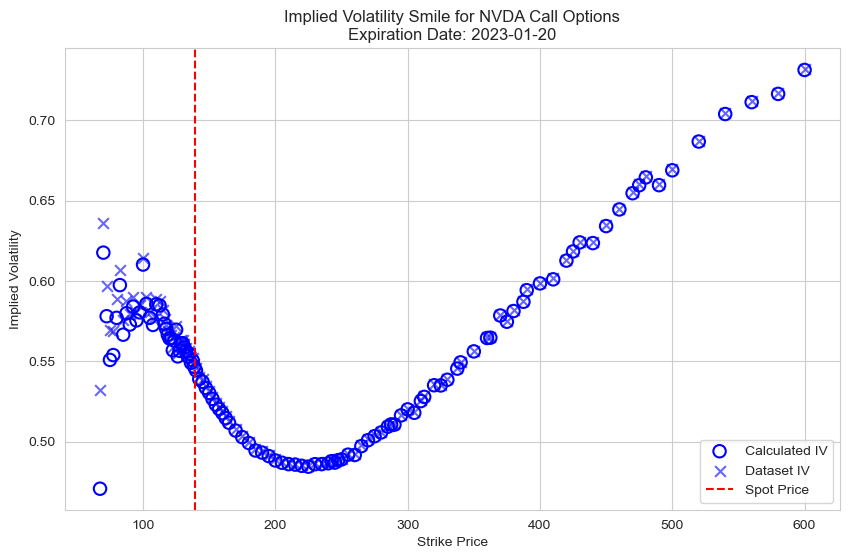

In [9]:
# Example: Use a specific target date instead of an index
# You can specify any date, and the function will find the closest available expiration date
target_date = "2023-01-30"  # Or use a date from your data

# Pick a security id
ticker = "NVDA"
exdate_id = 10

call_entries, spot_price, r, t, actual_exdate = get_implied_call_volatilities_for_ticker_and_exdate(ticker, target_date, verbose=True)

valid_iv = call_entries[call_entries['implied_volatility_calculation'].notna()].copy()
invalid_iv = call_entries[call_entries['implied_volatility_calculation'].isna()].copy()
print(f"Valid IV entries: {valid_iv.shape[0]}, Invalid IV entries: {invalid_iv.shape[0]}")
if invalid_iv.shape[0] > 0:
    # Print the invalid entries for debugging
    print("Invalid IV entries:")
    print(invalid_iv[['strike_price', 'implied_volatility_calculation', 'impl_volatility']])

plot_implied_volatility_smile(call_entries, ticker, spot_price, r, t, actual_exdate)

Note that for deep in the money options, the implied volatility is poorly defined, because the option's price is dominated by the intrinsic value of immediate exercise. At this region, both the database and the simulation yields undefined IV.

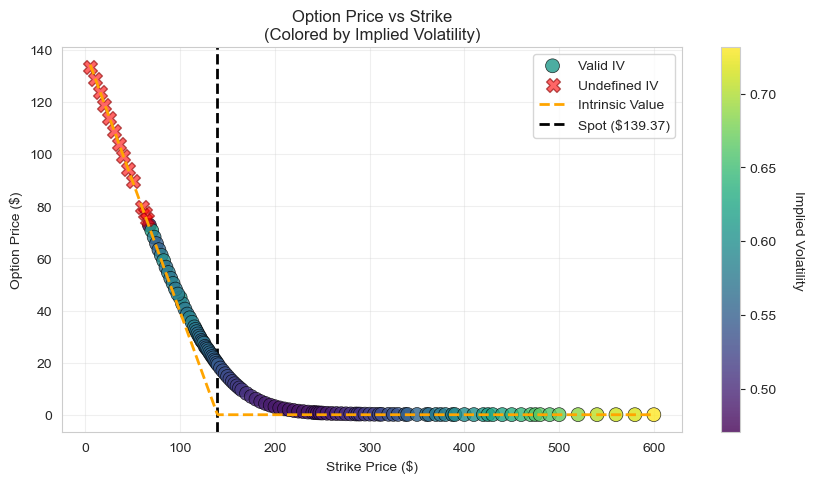

In [10]:
# Create a figure with three subplots
fig = plt.figure(figsize=(10, 5))

call_entries['market_price'] = 0.5 * (call_entries['best_bid'] + call_entries['best_offer'])


# Separate valid and invalid IV entries
valid_iv = call_entries[call_entries['implied_volatility_calculation'].notna()].copy()
invalid_iv = call_entries[call_entries['implied_volatility_calculation'].isna()].copy()

# Plot 3: 3D-style view - Option Price colored by IV (with NaN shown in red)
# Valid IV points - colored by IV value
if len(valid_iv) > 0:
    scatter = plt.scatter(valid_iv['strike_price'], valid_iv['market_price'], 
                          c=valid_iv['implied_volatility_calculation'], 
                          cmap='viridis', s=100, alpha=0.8, edgecolors='black', linewidths=0.5,
                          label='Valid IV', zorder=3)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=20)

# Invalid IV points - shown in red
if len(invalid_iv) > 0:
    plt.scatter(invalid_iv['strike_price'], invalid_iv['market_price'], 
                c='red', s=100, alpha=0.6, marker='X', edgecolors='darkred', linewidths=1,
                label='Undefined IV', zorder=4)
    
# Add a line plot showing value of immediate exercise (intrinsic value)
# Sort by strike price first for proper line plotting
call_entries_sorted = call_entries.sort_values('strike_price')
def intrinsic_value_call(S0, K):
    return max(S0 - K, 0)
intrinsic_values = call_entries_sorted['strike_price'].apply(lambda K: intrinsic_value_call(spot_price, K))
plt.plot(call_entries_sorted['strike_price'], intrinsic_values, 
         color='orange', linestyle='--', linewidth=2, label='Intrinsic Value', zorder=5)


plt.axvline(x=spot_price, color='black', linestyle='--', linewidth=2, label=f'Spot (${spot_price:.2f})')
plt.xlabel("Strike Price ($)")
plt.ylabel("Option Price ($)")
plt.title(f"Option Price vs Strike\n(Colored by Implied Volatility)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Plotted ticker AMZN, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker MSFT, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker NVDA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker TSLA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%
Plotted ticker META, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


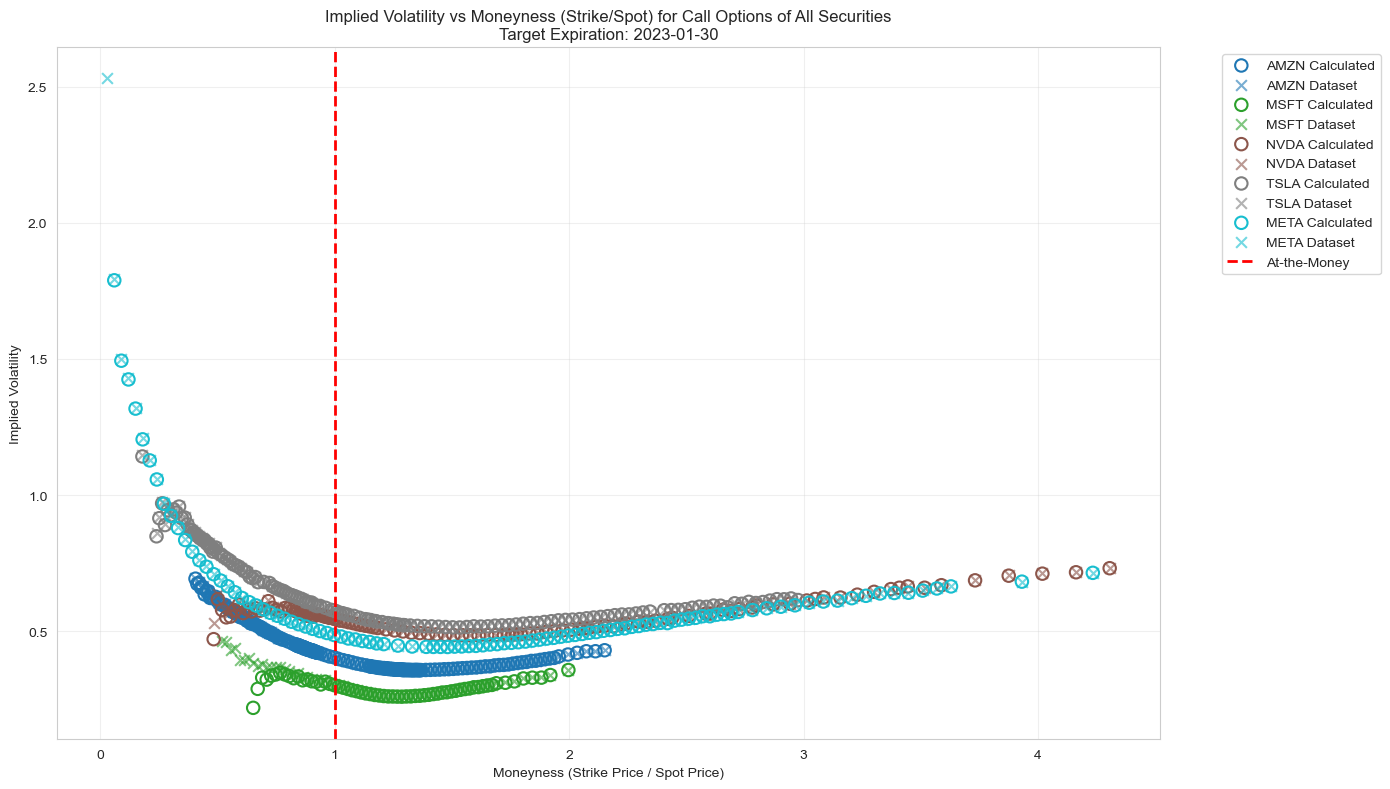

In [11]:
# Loop through all securities and analyze their implied volatilities
# This time, we'll put them all on a single plot with normalized strike prices

# Specify a target expiration date (all tickers will use the closest available date to this)
target_expiration_date = "2023-01-30"  # Adjust this to match your data range

all_tickers = df_security['ticker'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_tickers)))

for idx, ticker in enumerate(all_tickers):
    try:
        # Use the refactored function to get implied volatilities
        call_entries, spot_price, r, t, actual_exdate = get_implied_call_volatilities_for_ticker_and_exdate(
            ticker, target_expiration_date, verbose = False
        )
        
        if len(call_entries) == 0:
            print(f"No call options for ticker {ticker}")
            continue
        
        # Normalize strike prices by spot price (moneyness)
        call_entries['moneyness'] = call_entries['strike_price'] / spot_price
        
        # Plot calculated IV with hollow circles
        plt.scatter(call_entries['moneyness'], call_entries['implied_volatility_calculation'], 
                    marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                    label=f'{ticker} Calculated')
        
        # Plot dataset IV with x markers
        plt.scatter(call_entries['moneyness'], call_entries['impl_volatility'], 
                    marker='x', s=60, color=colors[idx], alpha=0.6,
                    label=f'{ticker} Dataset')
        
        contract_length = int(t * 365)
        print(f"Plotted ticker {ticker}, expiration: {actual_exdate}, contract length: {contract_length} days, rate: {r*100:.4f}%")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Add a vertical line at moneyness = 1 (at-the-money)
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='At-the-Money')

plt.title(f"Implied Volatility vs Moneyness (Strike/Spot) for Call Options of All Securities\nTarget Expiration: {target_expiration_date}")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We also examine the implied volatility as a function of the time to expiration

In [12]:
# Here, we pick the option with strike price closest to the spot price (ATM) for each expiration date

def get_implied_volatilities_for_all_exdates(ticker, verbose = False):
    # Get all unique expiration dates for this ticker
    df_options_ticker = df_options[df_options['ticker'] == ticker]
    all_exdates = sorted(df_options_ticker['exdate'].unique())
    if verbose:
        print(f"Found {len(all_exdates)} unique expiration dates")

    # Get spot price for reference
    starting_date = df_options['date'].unique()[0]
    spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]
    if verbose:
        print(f"Spot price: ${spot_price:.2f}")
    # Prepare data structures for plotting
    time_to_expiry_days = []
    calculated_ivs_atm = []
    dataset_ivs_atm = []
    strike_prices_used = []

    # Loop through each expiration date
    for exdate in tqdm(all_exdates, desc="Processing expiration dates"):
        try:
            # Use our refactored function to get implied volatilities for this expiration date
            call_entries, spot, r, t, actual_exdate = get_implied_call_volatilities_for_ticker_and_exdate(
                ticker, exdate, verbose= False
            )
            
            if len(call_entries) == 0:
                continue
            
            # Calculate contract length in days
            contract_length = int(t * 365)
            
            # Skip very short-dated options (less than 7 days)
            if contract_length < 7:
                continue
            
            # Find the ATM (at-the-money) option - strike closest to spot price
            call_entries['distance_to_atm'] = (call_entries['strike_price'] - spot).abs()
            atm_option = call_entries.loc[call_entries['distance_to_atm'].idxmin()]
            
            # Check if we have valid implied volatility
            if pd.notna(atm_option['implied_volatility_calculation']) and pd.notna(atm_option['impl_volatility']):
                time_to_expiry_days.append(contract_length)
                calculated_ivs_atm.append(atm_option['implied_volatility_calculation'])
                dataset_ivs_atm.append(atm_option['impl_volatility'])
                strike_prices_used.append(atm_option['strike_price'])
                
        except Exception as e:
            print(f"Error processing expiration date {exdate}: {e}")
            continue
    return time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used

Analyzing implied volatility term structure for TSLA


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 19.95it/s]


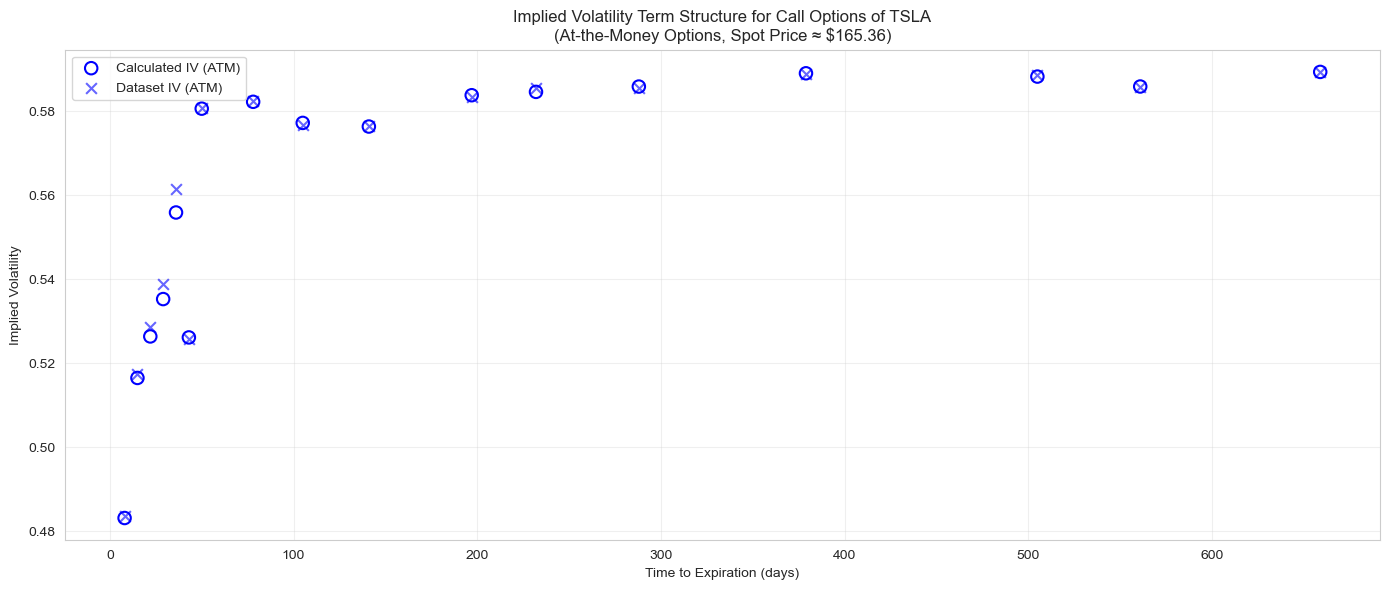

In [13]:
# Plot implied volatility as a function of time to expiration for at-the-money (ATM) options

# Pick a ticker to analyze
ticker = "TSLA"
print(f"Analyzing implied volatility term structure for {ticker}")

time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used = get_implied_volatilities_for_all_exdates(ticker = ticker)

# Plot the results
plt.figure(figsize=(14, 6))

plt.scatter(time_to_expiry_days, calculated_ivs_atm, 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV (ATM)')

plt.scatter(time_to_expiry_days, dataset_ivs_atm, 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV (ATM)')

plt.xlabel("Time to Expiration (days)")
plt.ylabel("Implied Volatility")
plt.title(f"Implied Volatility Term Structure for Call Options of {ticker}\n(At-the-Money Options, Spot Price ≈ ${spot_price:.2f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Processing expiration dates: 100%|██████████| 19/19 [00:00<00:00, 20.91it/s]


Plotted ticker AMZN, processed 18 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 38.68it/s]


Plotted ticker MSFT, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 30.51it/s]


Plotted ticker NVDA, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 18/18 [00:00<00:00, 19.87it/s]


Plotted ticker TSLA, processed 17 expiration dates


Processing expiration dates: 100%|██████████| 17/17 [00:00<00:00, 27.75it/s]

Plotted ticker META, processed 16 expiration dates


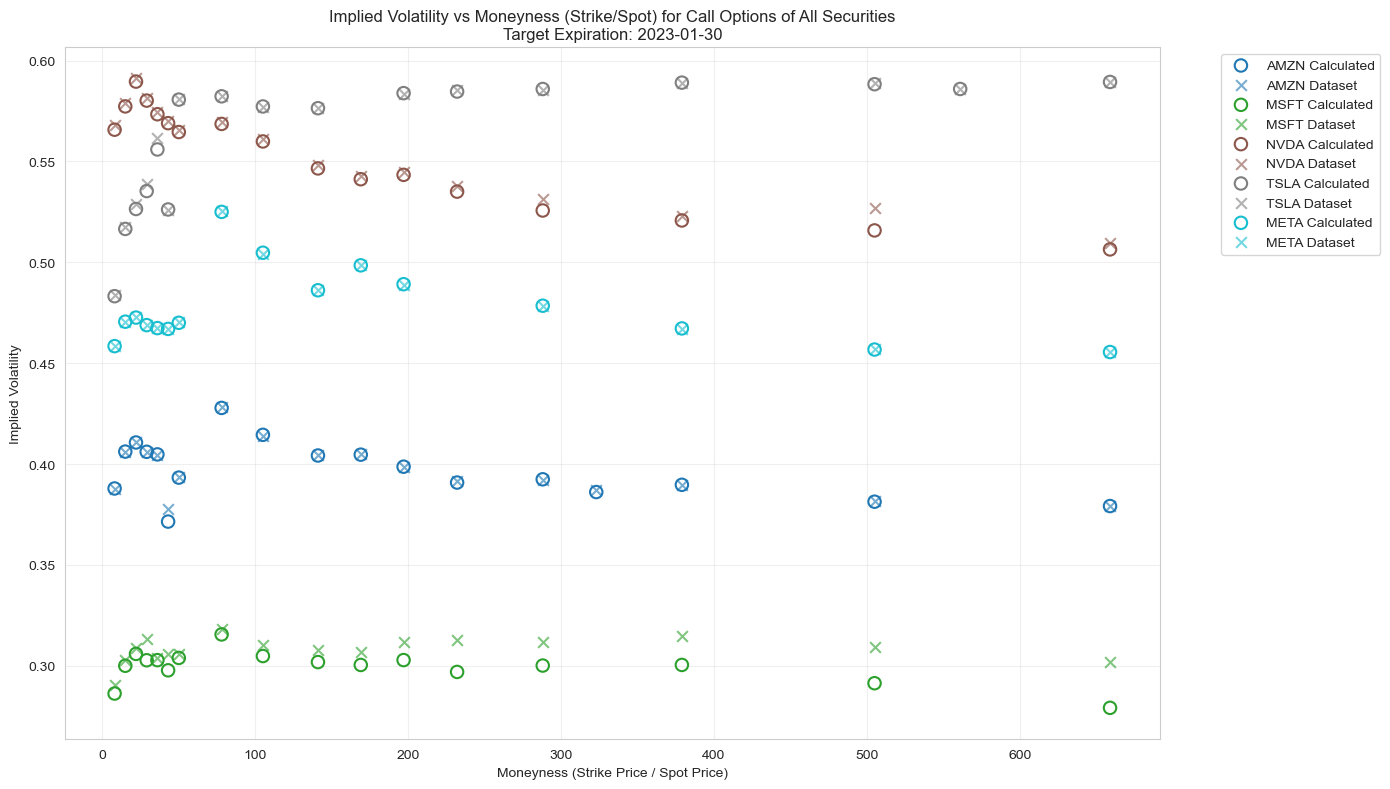

In [14]:
# Try to plot all of the tickers' IV against expiration date

# Specify a target expiration date (all tickers will use the closest available date to this)
target_expiration_date = "2023-01-30"  # Adjust this to match your data range

all_tickers = df_security['ticker'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_tickers)))

for idx, ticker in enumerate(all_tickers):
    try:
        time_to_expiry_days, calculated_ivs_atm, dataset_ivs_atm, strike_prices_used = get_implied_volatilities_for_all_exdates(ticker = ticker)

        # Plot the results
        plt.scatter(time_to_expiry_days, calculated_ivs_atm, 
                    marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                    label=f'{ticker} Calculated')

        plt.scatter(time_to_expiry_days, dataset_ivs_atm, 
                    marker='x', s=60, color=colors[idx], alpha=0.6,
                    label=f'{ticker} Dataset')


        print(f"Plotted ticker {ticker}, processed {len(time_to_expiry_days)} expiration dates")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Add a vertical line at moneyness = 1 (at-the-money)
plt.title(f"Implied Volatility vs Moneyness (Strike/Spot) for Call Options of All Securities\nTarget Expiration: {target_expiration_date}")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Implied Volatility Smile for Put options (binomial tree)

For American put options, we use the Cox-Ross-Rubinstein binomial tree to estimate its implied volatility. We also plot this against the Black-Scholes estimate for a sense of the difference.

In [19]:
from src.binomial_tree import BinomialTreeSimulator
from scipy.optimize import brentq

n_steps = 100


def implied_put_volatility_binomial_tree(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
        return tree.price_american_option() - market_price

    try:
        # The default xtol and rtol cause very long computation times
        # I loosen this up because this already gives good enough accuracy
        return brentq(objective, *sigma_bounds, xtol = 1e-3, rtol=1e-3)
    except ValueError:
        return np.nan

In [22]:
from src.black_scholes import implied_volatility_put

def get_implied_put_volatilities_for_ticker_and_exdate(ticker, target_exdate=None, exdate_id=None, verbose=False):
    """
    Calculate implied volatilities for put options given a ticker and target expiration date.
    
    Parameters:
    -----------
    ticker : str
        Ticker symbol (e.g., 'AMZN', 'MSFT')
    target_exdate : str or datetime-like, optional
        Target expiration date. The function will find the closest available expiration date.
        Can be in format 'YYYY-MM-DD' or any format parseable by pd.to_datetime()
    exdate_id : int, optional
        If provided, use this index to select expiration date instead of target_exdate.
        Note: only one of target_exdate or exdate_id should be provided.
    
    Returns:
    --------
    tuple : (put_entries, spot_price, r, t, actual_exdate)
        put_entries : DataFrame with put options and calculated implied volatilities
        spot_price : float, current spot price of the stock
        r : float, risk-free interest rate
        t : float, time to expiration in years
        actual_exdate : str, the actual expiration date used (closest to target)
    """
    put_entries, spot_price, r, t, exdate = _get_option_entries_for_ticker_and_exdate(
        ticker, target_exdate, exdate_id, option_type='P', verbose=verbose
    )

    put_entries['implied_volatility_calculation'] = put_entries.apply(
        lambda row: implied_put_volatility_binomial_tree(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )

    put_entries['implied_volatility_bs'] = put_entries.apply(
        lambda row: implied_volatility_put(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )

    return put_entries, spot_price, r, t, exdate

Analyzing options for secid: 154402, ticker: META
Target expiration date: 2023-01-30
Closest available expiration date: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


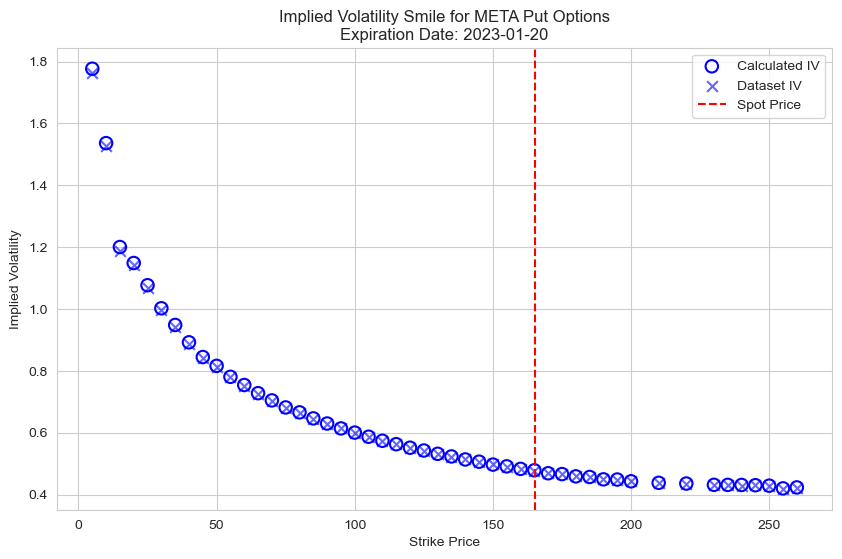

In [47]:
# Example: Use a specific target date instead of an index
# You can specify any date, and the function will find the closest available expiration date
target_date = "2023-01-30"  # Or use a date from your data

# Pick a security id
ticker = "META"
exdate_id = 10

put_entries, spot_price, r, t, actual_exdate = get_implied_put_volatilities_for_ticker_and_exdate(ticker, target_date, verbose=True)

plot_implied_volatility_smile(put_entries, ticker, spot_price, r, t, actual_exdate, label = "Put")

Note that for deep in the money options, the implied volatility is also poorly defined like in the case of call options.

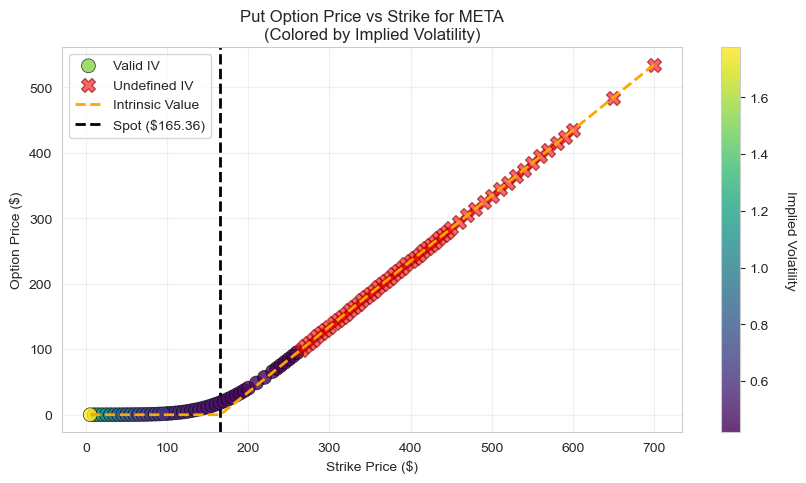

In [48]:
# Comprehensive visualization: Strike Price vs Option Price vs Implied Volatility
# This shows where IV is defined and where it becomes undefined

# Create a figure with three subplots
fig = plt.figure(figsize=(10, 5))

put_entries['market_price'] = 0.5 * (put_entries['best_bid'] + put_entries['best_offer'])


# Separate valid and invalid IV entries
valid_iv = put_entries[put_entries['impl_volatility'].notna()].copy()
invalid_iv = put_entries[put_entries['impl_volatility'].isna()].copy()
# valid_iv = put_entries[put_entries['implied_volatility_calculation'].notna()].copy()
# invalid_iv = put_entries[put_entries['implied_volatility_calculation'].isna()].copy()

# Plot 3: 3D-style view - Option Price colored by IV (with NaN shown in red)
# Valid IV points - colored by IV value
if len(valid_iv) > 0:
    scatter = plt.scatter(valid_iv['strike_price'], valid_iv['market_price'], 
                          c=valid_iv['implied_volatility_calculation'], 
                          cmap='viridis', s=100, alpha=0.8, edgecolors='black', linewidths=0.5,
                          label='Valid IV', zorder=3)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Implied Volatility', rotation=270, labelpad=20)

# Invalid IV points - shown in red
if len(invalid_iv) > 0:
    plt.scatter(invalid_iv['strike_price'], invalid_iv['market_price'], 
                c='red', s=100, alpha=0.6, marker='X', edgecolors='darkred', linewidths=1,
                label='Undefined IV', zorder=4)
    
# Add a line plot showing value of immediate exercise (intrinsic value)
# Sort by strike price first for proper line plotting
put_entries_sorted = put_entries.sort_values('strike_price')
def intrinsic_value_put(S0, K):
    return max(K - S0, 0)
intrinsic_values = put_entries_sorted['strike_price'].apply(lambda K: intrinsic_value_put(spot_price, K))
plt.plot(put_entries_sorted['strike_price'], intrinsic_values, 
         color='orange', linestyle='--', linewidth=2, label='Intrinsic Value', zorder=5)


plt.axvline(x=spot_price, color='black', linestyle='--', linewidth=2, label=f'Spot (${spot_price:.2f})')
plt.xlabel("Strike Price ($)")
plt.ylabel("Option Price ($)")
plt.title(f"Put Option Price vs Strike for {ticker}\n(Colored by Implied Volatility)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

We can also plot the implied volatility of put options from binomial tree against Black-Scholes model. In practice, we see that they agree with each other well for in-the-money options.

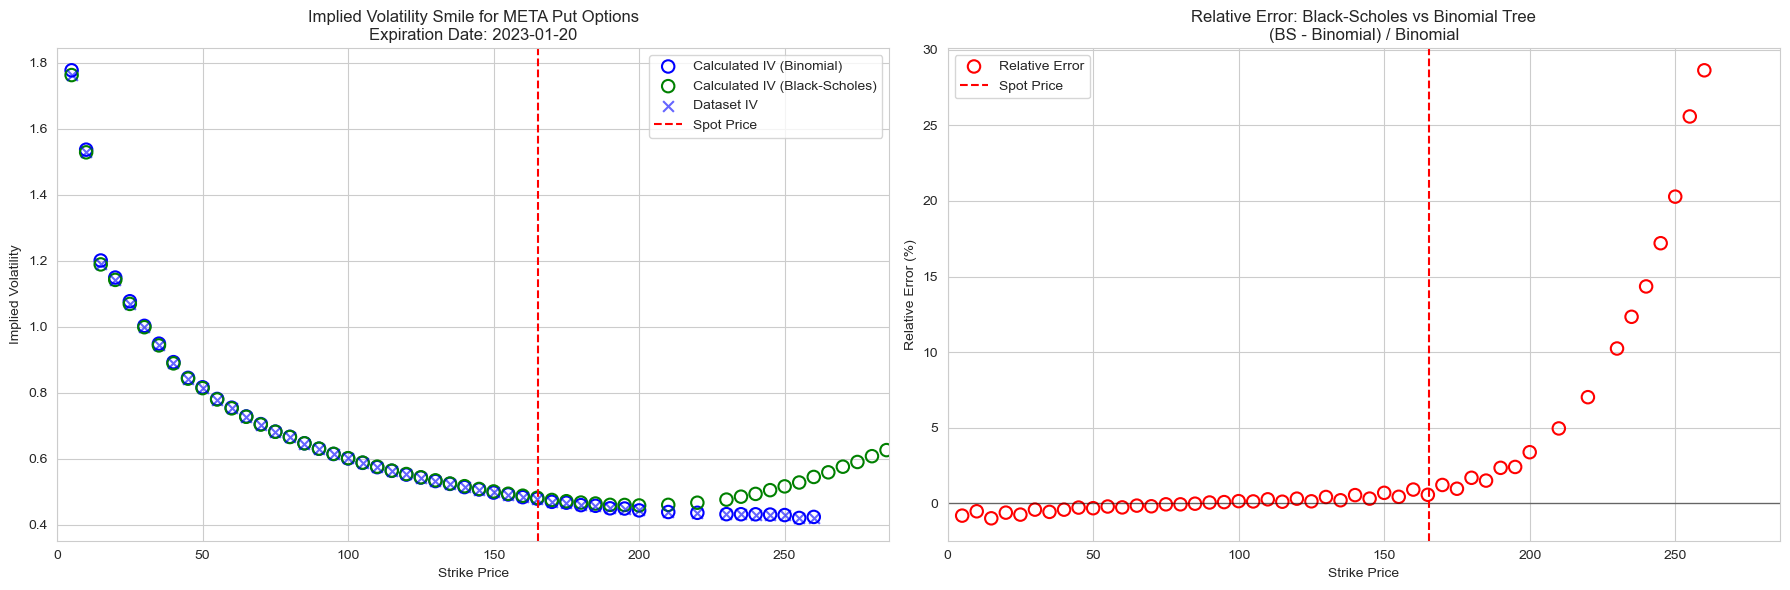

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Implied Volatility comparison
ax1.scatter(put_entries['strike_price'], put_entries['implied_volatility_calculation'], 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV (Binomial)')

ax1.scatter(put_entries['strike_price'], put_entries['implied_volatility_bs'], 
            marker='o', s=80, facecolors='none', edgecolors='green', linewidths=1.5,
            label='Calculated IV (Black-Scholes)')

# The data also comes with implied volatility directly
ax1.scatter(put_entries['strike_price'], put_entries['impl_volatility'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV')
ax1.axvline(x=spot_price, color='r', linestyle='--', label='Spot Price')
ax1.set_title(f'Implied Volatility Smile for {ticker} Put Options\nExpiration Date: {put_entries.exdate.iloc[0]}')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Implied Volatility')
# Set xlim to region where both calculated IV and dataset IV are well-defined (not NaN)
valid_entries = put_entries[put_entries['implied_volatility_calculation'].notna() & put_entries['impl_volatility'].notna()]
if len(valid_entries) > 0:
    ax1.set_xlim(0, valid_entries['strike_price'].max()*1.1)
ax1.legend()
ax1.grid(True)

# Right plot: Relative error of BS estimate vs Binomial tree
# Calculate relative error: (BS - Binomial) / Binomial
put_entries['relative_error'] = (put_entries['implied_volatility_bs'] - put_entries['implied_volatility_calculation']) / put_entries['implied_volatility_calculation']

# Filter for entries where both are well-defined
valid_comparison = put_entries[(put_entries['implied_volatility_calculation'].notna()) & 
                                (put_entries['implied_volatility_bs'].notna())].copy()

ax2.scatter(valid_comparison['strike_price'], valid_comparison['relative_error'] * 100, 
            marker='o', s=80, facecolors='none', edgecolors='red', linewidths=1.5,
            label='Relative Error')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axvline(x=spot_price, color='r', linestyle='--', label='Spot Price')
ax2.set_title(f'Relative Error: Black-Scholes vs Binomial Tree\n(BS - Binomial) / Binomial')
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Relative Error (%)')
if len(valid_entries) > 0:
    ax2.set_xlim(0, valid_entries['strike_price'].max()*1.1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

We can estimate the american premium using the above calculation on implied volatility

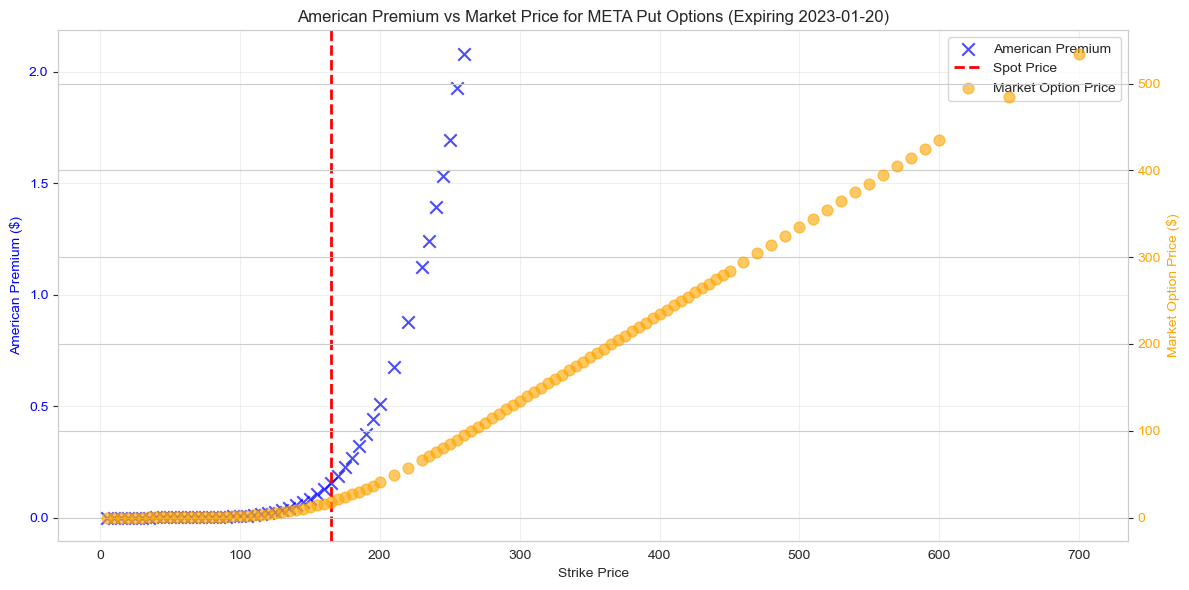

In [25]:
def american_premium(S0, K, t, r, sigma):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
    return tree.american_premium()
    
put_entries['american_premium'] = put_entries.apply(
    lambda row: american_premium(
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r,
        sigma=row['implied_volatility_calculation'])
    , axis=1
)

# Calculate European option price for comparison
put_entries['market_price'] = 0.5 * (put_entries['best_bid'] + put_entries['best_offer'])

# Create a dual-axis plot to show both American premium and market price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot American Premium on the left y-axis
ax1.scatter(put_entries['strike_price'], put_entries['american_premium'], 
            marker='x', s=80, color='blue', alpha=0.7,
            label='American Premium')
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("American Premium ($)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for market price
ax2 = ax1.twinx()
ax2.scatter(put_entries['strike_price'], put_entries['market_price'], 
            marker='o', s=60, color='orange', alpha=0.6,
            label='Market Option Price')
ax2.set_ylabel("Market Option Price ($)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a vertical line at the spot price
ax1.axvline(x=spot_price, color='red', linestyle='--', linewidth=2, label='Spot Price')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f"American Premium vs Market Price for {ticker} Put Options (Expiring {actual_exdate})")
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Finally, here is a graph showing the implied volatilities of all included tickers.

/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


Plotted ticker AMZN, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


Plotted ticker MSFT, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


Plotted ticker NVDA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


Plotted ticker TSLA, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:86: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)


Plotted ticker META, expiration: 2023-01-20, contract length: 141 days, rate: 3.0947%


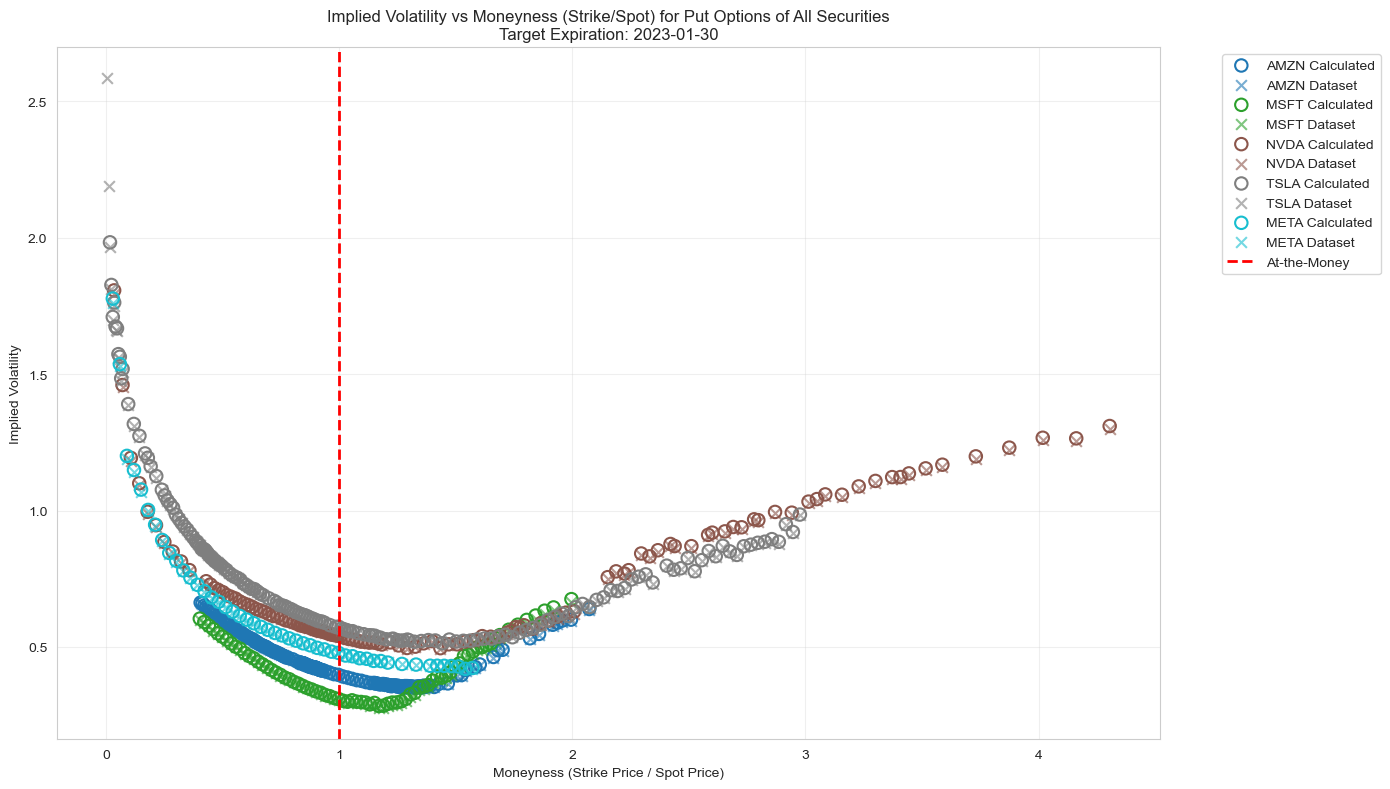

In [36]:
# Loop through all securities and analyze their implied volatilities
# This time, we'll put them all on a single plot with normalized strike prices

# Specify a target expiration date (all tickers will use the closest available date to this)
target_expiration_date = "2023-01-30"  # Adjust this to match your data range

all_tickers = df_security['ticker'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_tickers)))

for idx, ticker in enumerate(all_tickers):
    try:
        # Use the refactored function to get implied volatilities
        put_entries, spot_price, r, t, actual_exdate = get_implied_put_volatilities_for_ticker_and_exdate(
            ticker, target_expiration_date, verbose = False
        )

        if len(put_entries) == 0:
            print(f"No put options for ticker {ticker}")
            continue
        
        # Normalize strike prices by spot price (moneyness)
        put_entries['moneyness'] = put_entries['strike_price'] / spot_price

        # Plot calculated IV with hollow circles
        plt.scatter(put_entries['moneyness'], put_entries['implied_volatility_calculation'], 
                    marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                    label=f'{ticker} Calculated')
        
        # Plot dataset IV with x markers
        plt.scatter(put_entries['moneyness'], put_entries['impl_volatility'], 
                    marker='x', s=60, color=colors[idx], alpha=0.6,
                    label=f'{ticker} Dataset')
        
        contract_length = int(t * 365)
        print(f"Plotted ticker {ticker}, expiration: {actual_exdate}, contract length: {contract_length} days, rate: {r*100:.4f}%")
        
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Add a vertical line at moneyness = 1 (at-the-money)
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='At-the-Money')

plt.title(f"Implied Volatility vs Moneyness (Strike/Spot) for Put Options of All Securities\nTarget Expiration: {target_expiration_date}")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Conclusion

In this notebook, we analyzed the American options across multiple tickers. We computed the implied volatility smiles of the American call options, before simulating the behavior of their corresponding put options, compared the binomial tree method with the European Black-Scholes results. The comparison reveals:

1. **Agreement for OTM/ATM options**: Both models produce similar implied volatilities for out-of-the-money and at-the-money put options, where early exercise is less valuable.

2. **Divergence for ITM options**: As puts move deeper in-the-money, the models can diverge as the American early exercise premium becomes more significant.

3. **American Premium**: The American premium (the value of the early exercise feature) increases with strike price, becoming most valuable for deep in-the-money puts where early exercise to capture the strike price becomes optimal, at similar region where the American IV diverges from the European ones.

The volatility smile across all tickers shows consistent patterns, with IV generally higher for out-of-the-money puts, reflecting market demand for downside protection.